In [1]:
import os
import gcsfs
import json
import numpy as np
import xarray as xr
from pathlib import Path
from datetime import datetime

In [2]:
from numba import njit, prange

def opts():
    return dict(
        parallel = False,
        fastmath = True,
        cache = True,
        nogil = True,
        error_model = "numpy"
    )

In [3]:
@njit(**opts())
def get_index(array, value):
    for index in range(array.size):
        if array[index]-value == 0.0:
            return index     
    return -1


def check_index(index):
    if index == -1:
        raise ValueError("value not found in array")
    return None

In [4]:
store = 'pangeo-argo-eke/data/EasyOneArgoTSLite_v0'

In [5]:
def get_gcs(path=None, asynchronous=True) -> gcsfs.core.GCSFileSystem:
    #with open('/home/jovyan/pangeo-181919-e7bc5bdaf4d5.json') as f:
    if not path:
        with open('pangeo-181919-e7bc5bdaf4d5.json') as f:
            token = json.load(f)
    elif path:
        with open(path) as f:
            token = json.load(f)
    return gcsfs.GCSFileSystem(token=token, asynchronous=asynchronous)

In [7]:
def safe_float(x):
    try:
        return float(x)
    except (ValueError, TypeError):
        return np.nan

In [8]:
def iter_csv_paths(root):
    for dirpath, dirnames, filenames in os.walk(root):
        for fname in filenames:
            if fname.endswith(".csv"):
                yield os.path.join(dirpath, fname)

In [9]:
N_profiles= 2651968
N_plevels = 107
DATA_ROOT = Path("/home/jovyan/EasyOneArgoTSLite/EasyOneArgoTSLite_20251015T172450Z/data")

In [10]:
p = T = S = Perr = Terr = Serr = np.nan
pindex = 2
p0 = 10.0

In [11]:
def data_extraction(p0, DATA_ROOT, N_profiles):
    
    temp_arr = np.full((N_profiles, 1), np.nan, dtype=np.float32)
    sal_arr = np.full((N_profiles, 1), np.nan, dtype=np.float32)
    p_err_arr = np.full((N_profiles, 1), np.nan, dtype=np.float32)
    t_err_arr = np.full((N_profiles, 1), np.nan, dtype=np.float32)
    s_err_arr = np.full((N_profiles, 1), np.nan, dtype=np.float32)

    start = datetime.now()
    paths=[]
    for i, path in zip(range(N_profiles), iter_csv_paths(DATA_ROOT)):
        paths.append(path)
        with open(path, "rb", buffering=1024 * 1024) as f:
            for line in f:
                if not line:
                    continue
        
                # skip other comment lines and the column header line
                if line.startswith(b"#") or line.startswith(b"pressure "):
                    continue
        
                pres, temp, sali, perr, terr, serr = line.split(b",")
                try:
                    p = float(pres)
                except ValueError:
                    continue
                if p != p0:
                    continue
                elif p == p0:
                    temp_arr[i] = safe_float(temp)
                    sal_arr[i] = safe_float(sali)
                    p_err_arr[i] = safe_float(perr)
                    t_err_arr[i] = safe_float(terr)
                    s_err_arr[i] = safe_float(serr)
                    break
        if len(paths) % 265000 == 0:
            print(datetime.now() - start)

    OUT_DIR = Path('/home/jovyan/EasyOneArgoTSLite/derived/'+str(int(p0))+'dbar')
    OUT_DIR.mkdir(parents=True, exist_ok=True)
    np.save(OUT_DIR / "temp_arr.npy", temp_arr)
    np.save(OUT_DIR / "sal_arr.npy", sal_arr)
    np.save(OUT_DIR / "p_err_arr.npy", p_err_arr)
    np.save(OUT_DIR / "t_err_arr.npy", t_err_arr)
    np.save(OUT_DIR / "s_err_arr.npy", s_err_arr)
    
    print("Saved to", OUT_DIR)
        

In [110]:
data_extraction(p0, DATA_ROOT, N_profiles)

0:11:17.050218
0:22:27.450517
0:31:31.112567
0:40:22.890917
0:49:24.837765
0:58:30.078495
1:07:30.297949
1:17:01.431940
1:26:38.535777
1:36:05.617594
Saved to /home/jovyan/EasyOneArgoTSLite/derived/10dbar


In [13]:
OUT_DIR = Path('/home/jovyan/EasyOneArgoTSLite/derived/'+str(int(p0))+'dbar')
T = np.load(OUT_DIR / "temp_arr.npy") 
S = np.load(OUT_DIR / "sal_arr.npy") 
Perr = np.load(OUT_DIR / "p_err_arr.npy")  
Terr = np.load(OUT_DIR / "t_err_arr.npy")  
Serr = np.load(OUT_DIR / "s_err_arr.npy")  

In [16]:
print("temp_arr shape:", T.shape)
print("sal_arr  shape:", S.shape)
print("p_err_arr shape:", Perr.shape)
print("t_err_arr shape:", Terr.shape)
print("s_err_arr shape:", Serr.shape)

temp_arr shape: (2651968, 1)
sal_arr  shape: (2651968, 1)
p_err_arr shape: (2651968, 1)
t_err_arr shape: (2651968, 1)
s_err_arr shape: (2651968, 1)


In [17]:
import zarr

gcs = get_gcs(path=None, asynchronous=False)
store = gcs.get_mapper("pangeo-argo-eke/data/EasyOneArgoTSLite_v0")

root = zarr.open_group(store, mode="r+")
print(root.tree())

/
├── latitude (2651968,) float32
├── longitude (2651968,) float32
├── paths (2651968,) <U37
├── pressure (107,) float64
├── pressure_error (2651968, 107) float32
├── profilelocation_index (2651968,) int64
├── salinity (2651968, 107) float32
├── salinity_error (2651968, 107) float32
├── temperature (2651968, 107) float32
├── temperature_error (2651968, 107) float32
└── time (2651968,) float64

In [19]:
T10    = T[:, 0]
S10    = S[:, 0]
Perr10 = Perr[:, 0]
Terr10 = Terr[:, 0]
Serr10 = Serr[:, 0]

print(T10.shape, S10.shape, Perr10.shape, Terr10.shape, Serr10.shape)

(2651968,) (2651968,) (2651968,) (2651968,) (2651968,)


In [ ]:
%%time
pindex = 2  # 10 dbar level

root["temperature"][:, pindex]        = T10
root["salinity"][:, pindex]          = S10
root["pressure_error"][:, pindex]    = Perr10
root["temperature_error"][:, pindex] = Terr10
root["salinity_error"][:, pindex]    = Serr10


In [21]:
gcs = get_gcs(path=None, asynchronous=False)
mapper = gcs.get_mapper("pangeo-argo-eke/data/EasyOneArgoTSLite_v0")

ds = xr.open_zarr(mapper, consolidated=True)
ds

<xarray.Dataset> Size: 6GB
Dimensions:                (profilelocation_index: 2651968, pressure: 107,
                            latitude: 2651968, longitude: 2651968, time: 2651968)
Coordinates:
  * profilelocation_index  (profilelocation_index) int64 21MB 0 1 ... 2651967
  * pressure               (pressure) float64 856B 2.0 5.0 ... 5.8e+03 6e+03
  * latitude               (latitude) float32 11MB 26.98 26.5 ... 3.771 4.691
  * longitude              (longitude) float32 11MB -86.58 -86.33 ... -35.01
  * time                   (time) datetime64[ns] 21MB 2016-05-09T11:26:04 ......
Data variables:
    paths                  (profilelocation_index) <U37 392MB dask.array<chunksize=(2651968,), meta=np.ndarray>
    pressure_error         (profilelocation_index, pressure) float32 1GB dask.array<chunksize=(2651968, 1), meta=np.ndarray>
    salinity               (profilelocation_index, pressure) float32 1GB dask.array<chunksize=(2651968, 1), meta=np.ndarray>
    salinity_error         (profilelocation_index, pressure) float32 1GB dask.array<chunksize=(2651968, 1), meta=np.ndarray>
    temperature            (profilelocation_index, pressure) float32 1GB dask.array<chunksize=(2651968, 1), meta=np.ndarray>
    temperature_error      (profilelocation_index, pressure) float32 1GB dask.array<chunksize=(2651968, 1), meta=np.ndarray>
Attributes:
    description:       EasyOneArgoTSLite 2025-10 version's variables, stored ...
    filename:          pangeo-argo-eke/data/EasyOneArgoTSLite_v0
    initialized_date:  2025-11-20 13:36:07.260817

In [14]:
OUT_DIR = Path("/home/jovyan/EasyOneArgoTSLite/derived")
latitudes = np.load(OUT_DIR / "latitudes.npy")
longitudes = np.load(OUT_DIR / "longitudes.npy")
#times = np.load(OUT_DIR / "times.npy")
lon_180180 = longitudes.copy()
ind = np.where(longitudes>180.0)
ind_neg180 = np.where(longitudes==-180.0)
lon_180180[ind] = lon_180180[ind] - 360.0
lon_180180[ind_neg180] = lon_180180[ind_neg180] + 360.0

In [57]:
T_stored = ds.isel(pressure=2).temperature.to_numpy()
T_stored.shape

(2651968,)

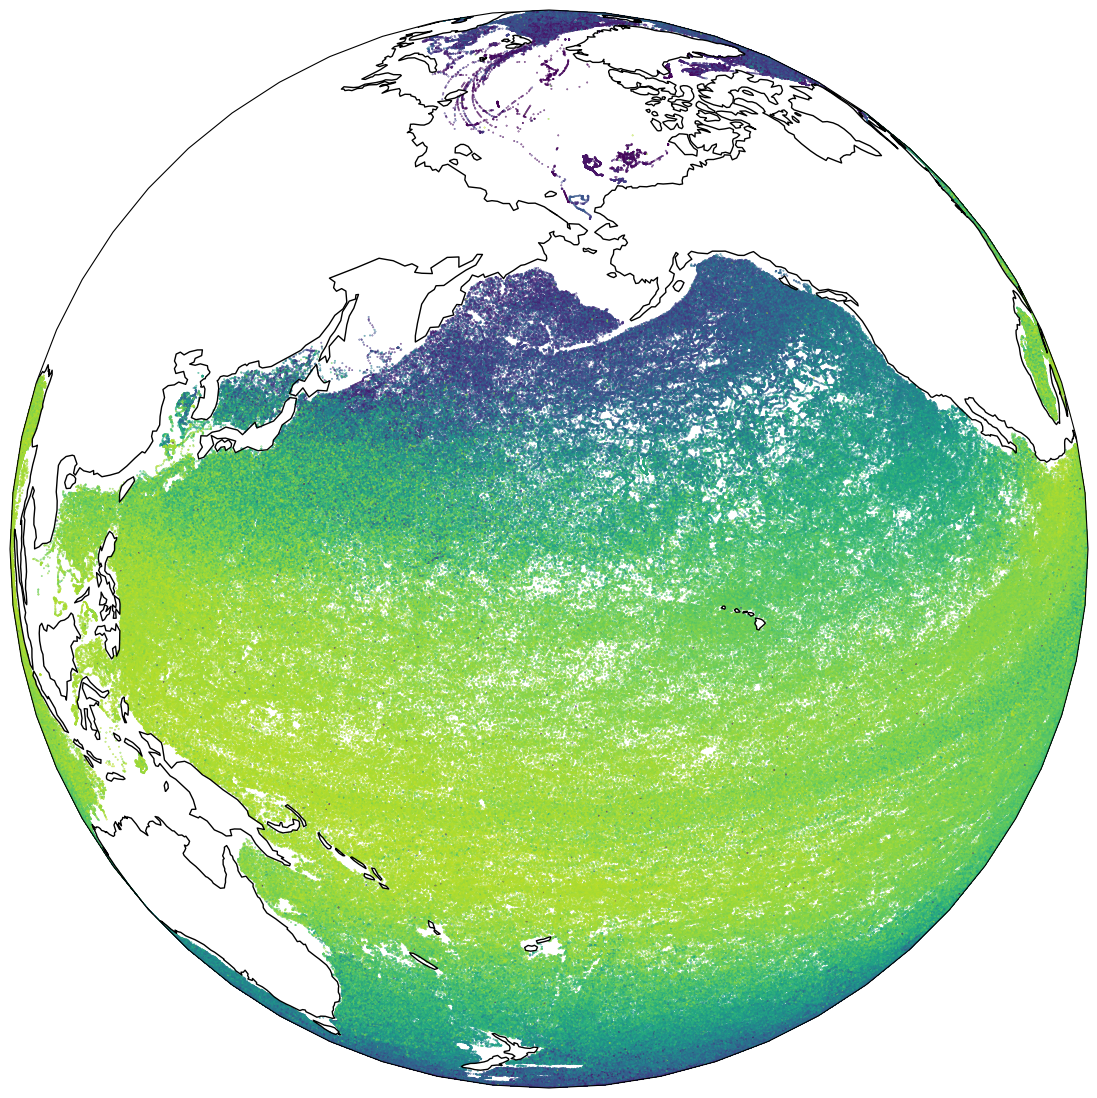

In [59]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
proj = ccrs.Orthographic(central_longitude=-180.0, central_latitude=30.0)
fig = plt.figure(figsize=(14, 14))
ax = plt.axes(projection=proj)
ax.set_global()
ax.coastlines()
ax.scatter(
    lon_180180,
    latitudes,
    c=T_stored,
    s=0.1,
    transform=ccrs.PlateCarree(),
)
plt.show()